In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7060546036095925309, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4253956779515421197
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15476975826128366639
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4012202785792971895
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%autosave 100

In [0]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
total = 8900000

quizes = np.empty((total, 81), np.float32)
solutions = np.empty((total, 81), np.int64)

i=0
f = open("/content/drive/My Drive/Colab Notebooks/__9m_sudoku.csv")
for line in f:
    quiz, solution = line.strip().split(",")
    quizes[i] = [int(i) for i in quiz]
    solutions[i] = [int(i) for i in solution]
    i += 1
    if i % (total // 10) == 0: print("loaded", i//(total // 100), "%")
    if i >= total: break

quizes = quizes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

print("quizes\n", quizes.shape, quizes[0])
print("solutions\n", solutions.shape, solutions[0])

#shuf = np.random.permutation(quizes.shape[0])
#print("shuf", shuf.shape, shuf)
#quizes = quizes[shuf]
#solutions = solutions[shuf]

print("quizes\n", quizes.shape, quizes[0])
print("solutions\n", solutions.shape, solutions[0])

loaded 10 %
loaded 20 %
loaded 30 %
loaded 40 %
loaded 50 %
loaded 60 %
loaded 70 %
loaded 80 %
loaded 90 %
loaded 100 %
quizes
 (8900000, 9, 9) [[0. 0. 1. 6. 7. 0. 2. 0. 5.]
 [0. 6. 0. 0. 3. 5. 0. 0. 0.]
 [5. 8. 2. 0. 1. 0. 3. 0. 7.]
 [6. 7. 8. 5. 0. 0. 0. 3. 4.]
 [0. 0. 4. 3. 6. 1. 0. 0. 0.]
 [0. 1. 0. 0. 4. 7. 0. 5. 0.]
 [1. 0. 5. 0. 8. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 5. 0. 2.]
 [0. 2. 7. 4. 0. 0. 0. 0. 0.]]
solutions
 (8900000, 9, 9) [[4 3 1 6 7 8 2 9 5]
 [7 6 9 2 3 5 4 8 1]
 [5 8 2 9 1 4 3 6 7]
 [6 7 8 5 2 9 1 3 4]
 [9 5 4 3 6 1 7 2 8]
 [2 1 3 8 4 7 9 5 6]
 [1 9 5 7 8 2 6 4 3]
 [8 4 6 1 9 3 5 7 2]
 [3 2 7 4 5 6 8 1 9]]
quizes
 (8900000, 9, 9) [[0. 0. 1. 6. 7. 0. 2. 0. 5.]
 [0. 6. 0. 0. 3. 5. 0. 0. 0.]
 [5. 8. 2. 0. 1. 0. 3. 0. 7.]
 [6. 7. 8. 5. 0. 0. 0. 3. 4.]
 [0. 0. 4. 3. 6. 1. 0. 0. 0.]
 [0. 1. 0. 0. 4. 7. 0. 5. 0.]
 [1. 0. 5. 0. 8. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 5. 0. 2.]
 [0. 2. 7. 4. 0. 0. 0. 0. 0.]]
solutions
 (8900000, 9, 9) [[4 3 1 6 7 8 2 9 5]
 [7 6 9 2 3 5 4 8 1]
 [5

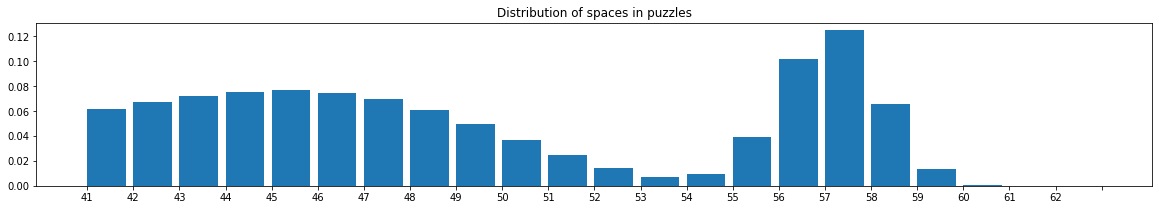

In [0]:
num_zeros = np.empty((total), np.float32)
zeros_ = np.zeros_like(quizes[0])
for i in range(num_zeros.shape[0]):
    num_zeros[i] = np.sum(np.equal(zeros_, quizes[i]))

plt.figure(figsize=(20, 3))
n, bins, patches = plt.hist(num_zeros, len(np.unique(num_zeros)), width=0.8, density=True)
plt.xticks(ticks=bins, labels=list(map(int, np.unique(num_zeros))), horizontalalignment='center')
plt.title("Distribution of spaces in puzzles")
plt.show()

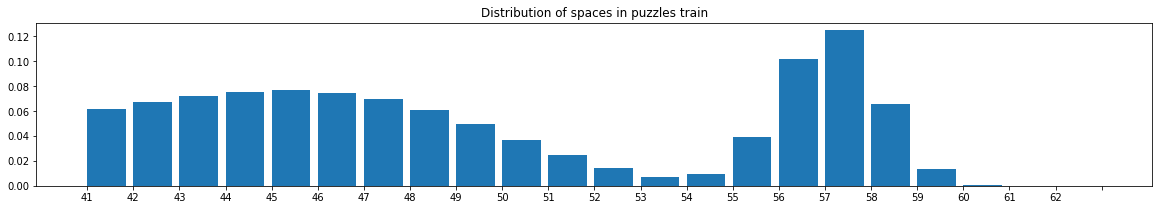

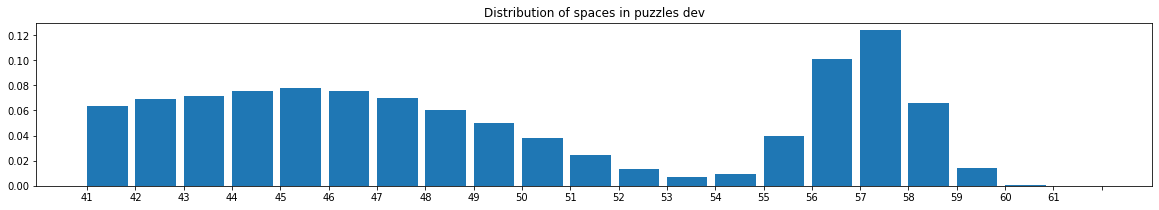

In [0]:
plt.figure(figsize=(20, 3))
n, bins, patches = plt.hist(num_zeros[total*1//100:], len(np.unique(num_zeros[total*1//100:])), width=0.8, density=True)
plt.xticks(ticks=bins, labels=list(map(int, np.unique(num_zeros[total*1//100:]))), horizontalalignment='center')
plt.title("Distribution of spaces in puzzles train")
plt.show()

plt.figure(figsize=(20, 3))
n, bins, patches = plt.hist(num_zeros[:total*1//100], len(np.unique(num_zeros[:total*1//100])), width=0.8, density=True)
plt.xticks(ticks=bins, labels=list(map(int, np.unique(num_zeros[:total*1//100]))), horizontalalignment='center')
plt.title("Distribution of spaces in puzzles dev")
plt.show()

In [0]:
class ConvNet(nn.Module):
  def __init__(self, c_in, c_out, filt=3, stride=1, padding=1):
    super(ConvNet, self).__init__()

    #self.dropout = nn.Dropout2d(p=0.05)
    self.conv = nn.Conv2d(c_in, c_out, (filt, filt), stride=stride, padding=padding)
    self.bn = nn.BatchNorm2d(c_out)
  
  def forward(self, x):
    n, c, h, w = x.shape
    #z = F.relu(self.bn(self.conv(self.dropout(x))))
    z = F.relu(self.bn(self.conv(x)))
    return z

class ResNet(nn.Module):
  def __init__(self, c_in, c_out, filt=3, stride=1, padding=1):
    super(ResNet, self).__init__()

    self.conv1 = nn.Conv2d(c_in, c_out, (filt, filt), stride=stride, padding=padding)
    self.bn1 = nn.BatchNorm2d(c_out)
    self.conv2 = nn.Conv2d(c_in, c_out, (filt, filt), stride=stride, padding=padding)
    self.bn2 = nn.BatchNorm2d(c_out)
  
  def forward(self, x):
    n, c, h, w = x.shape
    z1 = F.relu(self.bn1(self.conv1(x)))
    z2 = F.relu(self.bn2(self.conv2(z1)) + x)
    return z2


class Res2Net(nn.Module):
  def __init__(self, c_in, c_out, filt=3, stride=1, padding=1):
    super(Res2Net, self).__init__()

    self.conv1 = nn.Conv2d(c_in, c_out, (filt, filt), stride=stride, padding=padding)
    self.bn1 = nn.BatchNorm2d(c_out)
    self.conv2 = nn.Conv2d(c_in, c_out, (5, 5), stride=stride, padding=2)
    self.bn2 = nn.BatchNorm2d(c_out)
  
  def forward(self, x):
    n, c, h, w = x.shape
    z1 = F.relu(self.bn1(self.conv1(x)))
    z2 = F.relu(self.bn2(self.conv2(z1)) + x)
    return z2

# n1 - number of conv layers with kernel size (3, 3) - try to learn local
# n2 - number of conv layers with kernel size (9, 9) - try to learn global
# c_mid - number of kernels in conv layers
class SudokuNet(nn.Module):
  # !!! c_out should be 10 !!!
  def __init__(self, n, n2, c_mid, c_in=1, c_out=10):
    super(SudokuNet, self).__init__()
    self.conv1 = ConvNet(c_in, c_mid)

    self.seq = nn.Sequential()
    for i in range(n):
      self.seq.add_module(str(i), Res2Net(c_mid, c_mid, 3, 1, 1))

    self.seq2 = nn.Sequential()
    for i in range(n2):
      self.seq2.add_module(str(i), ResNet(c_mid, c_mid, 9, 1, 4))


    self.convLast = nn.Conv2d(c_mid, c_out, (3,3), stride=1, padding=1)
    self.logsoftmax = nn.LogSoftmax(dim=1)

    
  def forward(self, x):
    z = self.conv1(x)
    z = self.seq(z)
    z = self.seq2(z)
    z = self.logsoftmax(self.convLast(z))
    return z


In [0]:
def is_valid(y):
  uniques = {1,2,3,4,5,6,7,8,9}
  y = y.cpu().detach().numpy()
  
  for i in range(9):
    if set(y[i].ravel()) != uniques:
      return False
    if set(y[:, i].ravel()) != uniques:
      return False
    if set(y[(i//3) * 3 : (i//3 + 1) * 3, (i%3) * 3 : (i%3 + 1) * 3].ravel()) != uniques:
      return False
  return True

def get_solutions(y_, y):
  ans = y.clone().detach()
  for i in range(len(y)):
    if is_valid(y_[i]):
      ans[i] = y_[i]
      print('Valid!')

  return ans


# train in range [start, end) with batch_size
# change start/end to reduce training time
def train_epoch(model, opt, loss, batch_size, start=total*1//100, end=total):
    model.train(True)
    for i in range(start, end, batch_size):
        x = quizes[i:i+batch_size]
        y = solutions[i:i+batch_size]
        x = x[:, np.newaxis]
        
        X, y = torch.from_numpy(x), torch.from_numpy(y)

        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        opt.zero_grad()
        y_ = model(X)
        #y_ok = get_solutions(y_, y)
        #loss_value = loss(y_, y_ok)
        loss_value = loss(y_, y)
        loss_value.backward()
        opt.step()

In [0]:
# get accuracy in range [start, end) with batch_size
# change start/end to reduce running time
# choose wisely, so that |train| : |test| = 9 : 1 (or 99 : 1)
def get_accuracy(model, batch_size, start=0, end=total*1//100):
    model.train(mode=False)

    total_samples = 0
    total_correct = 0
    known_samples = 0
    known_correct = 0
    
    zeros_count = 0

    for i in range(start, end, batch_size):
        x = quizes[i:i+batch_size]
        y = solutions[i:i+batch_size]
        x = x[:, np.newaxis]

        X, y = torch.from_numpy(x), torch.from_numpy(y)
        zeros_ = torch.zeros_like(y)

        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
            x_ = torch.from_numpy(quizes[i:i+batch_size]).cuda()
            zeros_ = zeros_.cuda()

        y_ = model(X)
        _, y_ = torch.max(y_, axis=1)
        
        total_samples += 81 * batch_size
        #y_ok = get_solutions(y_, y)
        #sum_ = torch.sum(torch.eq(y_, y_ok).type(torch.FloatTensor))
        sum_ = torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        total_correct += sum_.item()

        known_samples += 81 * batch_size - np.sum(num_zeros[i:i+batch_size])
        known_sum_ = torch.sum(torch.eq(y_, x_).type(torch.FloatTensor))
        known_correct += known_sum_.item()

        zeros_count += torch.sum(torch.eq(y_, zeros_).type(torch.FloatTensor)).item()

    return total_correct / total_samples, known_correct / known_samples, (total_correct - known_correct) / (total_samples - known_samples), zeros_count

In [0]:
def train_net(epochs, batch_size, test_batch_size):
    total_accuracies = []
    known_accuracies = []
    unknown_accuracies = []
    zeros_count = []
    for epoch in range(epochs):
        
        train_epoch(model, opt, loss, batch_size=batch_size)
        acc, kn, unkn, zc = get_accuracy(model, batch_size=test_batch_size)
        total_accuracies.append(acc)
        known_accuracies.append(kn)
        unknown_accuracies.append(unkn)
        zeros_count.append(zc)
        print(f'epoch: [{epoch+1}/{epochs}], accuracy: {acc}, known_accuracy: {kn}, unknown_accuracy: {unkn}, zeros_count: {zc}')

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'total_accuracies': total_accuracies,
            'known_accuracies': known_accuracies,
            'unknown_accuracies': unknown_accuracies,
            'zeros_count': zeros_count,
            'epochs': epochs},
        "/content/drive/My Drive/Colab Notebooks/__9m_res2net_model_" + str(n) + "_" + str(n2) + "_" + str(c_mid) + "_" + str(total) + "_e" + str(epoch) + ".tar")

    return total_accuracies, known_accuracies, unknown_accuracies, zeros_count

In [0]:
n = 10
n2 = 0
c_mid=100
model = SudokuNet(n=n, n2=n2, c_mid=c_mid)
if torch.cuda.is_available():
    print("cuda")
    model.cuda()
else:
    print("cpu")
# Adam seems to work better
#opt = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
opt = optim.Adam(model.parameters())
loss = nn.NLLLoss()

cuda


In [0]:
%%time
epochs=10
total_accuracies, known_accuracies, unknown_accuracies, zeros_count = train_net(epochs=epochs, batch_size=5000, test_batch_size=500)

epoch: [1/10], accuracy: 0.8208893050353725, known_accuracy: 0.999996451921586, unknown_accuracy: 0.7059156060040455, zeros_count: 0.0
epoch: [2/10], accuracy: 0.8545802469135803, known_accuracy: 0.9999996451921586, unknown_accuracy: 0.7612316205652429, zeros_count: 0.0
epoch: [3/10], accuracy: 0.8700571507837426, known_accuracy: 1.0, unknown_accuracy: 0.7866433378968987, zeros_count: 0.0
epoch: [4/10], accuracy: 0.8779407684838396, known_accuracy: 0.9999992903843172, unknown_accuracy: 0.7995881175418333, zeros_count: 0.0
epoch: [5/10], accuracy: 0.8861513386045221, known_accuracy: 0.9999992903843172, unknown_accuracy: 0.8130692736460594, zeros_count: 0.0
epoch: [6/10], accuracy: 0.8924383409626855, known_accuracy: 1.0, unknown_accuracy: 0.8233916165384336, zeros_count: 0.0
epoch: [7/10], accuracy: 0.8953852129282841, known_accuracy: 0.9999943230745377, unknown_accuracy: 0.8282338091178532, zeros_count: 0.0
epoch: [8/10], accuracy: 0.8963993619087252, known_accuracy: 0.9999932586510135

([<matplotlib.axis.XTick at 0x7f06cb768e48>,
 <a list of 10 Text major ticklabel objects>)

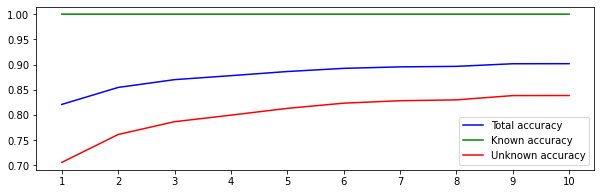

In [0]:
dat = pd.DataFrame({'a':np.array(total_accuracies), 'kn':np.array(known_accuracies), 'unkn':np.array(unknown_accuracies), 'zc':np.array(zeros_count)})
dat['epoch'] = np.arange(epochs)+1

fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(dat['epoch'], dat['a'], color='blue', label='Total accuracy')
ax.plot(dat['epoch'], dat['kn'], color='green', label='Known accuracy')
ax.plot(dat['epoch'], dat['unkn'], color='red', label='Unknown accuracy')
ax.legend()

plt.xticks(dat['epoch'])
#plt.savefig("/content/drive/My Drive/Colab Notebooks/__9m_res2net_acc_" + str(n) + "_" + str(n2) + "_" + str(c_mid) + "_" + str(total) + ".png")

In [0]:

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'total_accuracies': total_accuracies,
            'known_accuracies': known_accuracies,
            'unknown_accuracies': unknown_accuracies,
            'zeros_count': zeros_count,
            'epochs': epochs
            }, "/content/drive/My Drive/Colab Notebooks/__9m_res2net_model_" + str(n) + "_" + str(n2) + "_" + str(c_mid) + "_" + str(total) + ".tar")

